In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv


%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [4]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



In [5]:

z_min, z_max = 0.4, 6
SM_min, SM_max = 10, 12.5
    
sub1 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
#hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds = ([11.0*1e-7, 12.5, 0.99], [14.5*1e-7, 15.5, 1.01]) # fix alpha to 1
hod_params, pcov = sub1.fit_hod(p0=[12.3*1e-7, 13.5, 1.0]) 


results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


HOD fit results: M_min = 10^12.27, M_1 = 10^13.80, alpha = 1.18


<>:26: SyntaxWarning: invalid escape sequence '\i'
<>:26: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1742758/2630096652.py:26: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


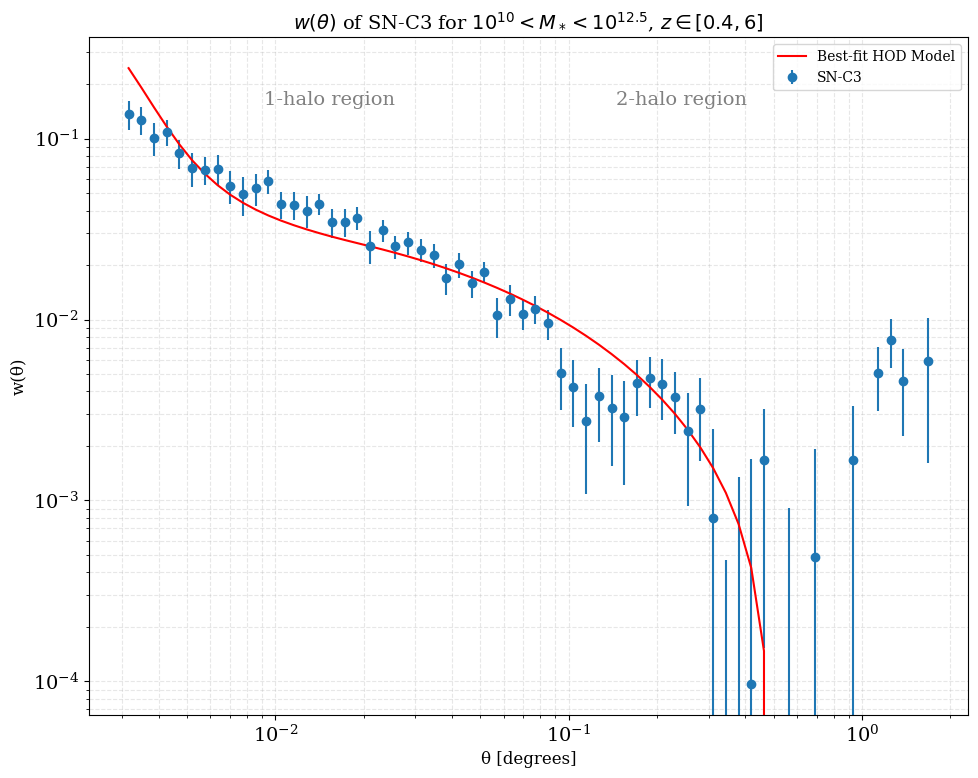

In [6]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

# Model prediction with best-fit parameters
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')

plt.savefig(f"wtheta_SN_C3_HOD_SM_{SM_min}_{SM_max}_{z_min}_{z_max}.png")

plt.tight_layout()
plt.show()



HOD fit results: M_min = 10^12.27, M_1 = 10^13.80, alpha = 1.18


In [7]:
results = sub1.get_results()

# Extract values
A = results['power_law_params'][0]
z_mean = (sub1.z_min + sub1.z_max) / 2
delta_z = sub1.z_max - sub1.z_min
delta = 0.8  



In [8]:
analysis = dv.SubsampleAnalysis(delta=delta, A=A, z_mean=z_mean, delta_z=delta_z)

r0 = analysis.calculate_r0()

print(f"Comoving correlation length r₀ = {r0:.2f} Mpc/h")

<class 'numpy.float64'>
1.8
Comoving correlation length r₀ = 11.51 Mpc/h


In [9]:
# Define redshift and stellar mass bins
z_bins = [(0.6, 0.8), (0.8, 1.0)]
#SM_bins = [(9, 12.5), (10, 12.), (11.0, 12.5)]
SM_bins = [ (10.0, 12.5)]


r0_results = []

for z_min, z_max in z_bins:
    for SM_min, SM_max in SM_bins:
        print(f"Processing bin: z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})")

        try:
            sub = dv.Selection(catalog=t, randoms=randoms,
                            z_min=z_min, z_max=z_max,
                            SM_min=SM_min, SM_max=SM_max,
                            config=config)
            
            # Fit HOD
            hod_params, _ = sub.fit_hod()
            results = sub.get_results()
            
            # Extract parameters for r0 calculation
            A = results['power_law_params'][0]
            z_mean = (z_min + z_max) / 2
            delta_z = z_max - z_min
            delta = 0.8  # or estimate from sample normalization
            
            # Compute r0
            analysis = dv.SubsampleAnalysis(delta=delta, A=A, z_mean=z_mean, delta_z=delta_z)
            r0 = analysis.calculate_r0()

            print(f"  → r₀ = {r0:.2f} Mpc/h")

            r0_results.append({
                'z_min': z_min,
                'z_max': z_max,
                'SM_min': SM_min,
                'SM_max': SM_max,
                'r0': r0,
                'N': results['N']
            })
        
        except Exception as e:
            print(f"  ⚠️ Failed for bin (z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})): {e}")


Processing bin: z=(0.6, 0.8), logSM=(10.0, 12.5)
<class 'numpy.float64'>
1.8
  → r₀ = 12.21 Mpc/h
Processing bin: z=(0.8, 1.0), logSM=(10.0, 12.5)
<class 'numpy.float64'>
1.8
  → r₀ = 3.07 Mpc/h


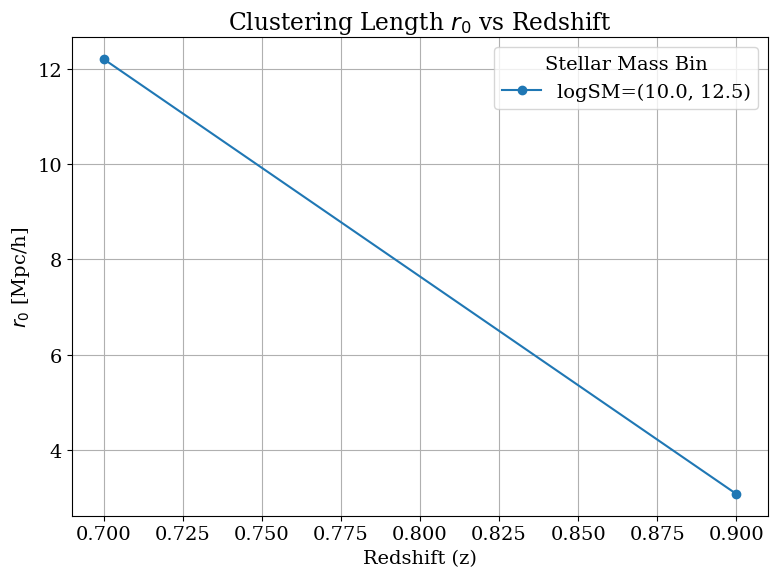

In [10]:

# Group r0 results by stellar mass threshold
from collections import defaultdict
import numpy as np

# Organize r0 results by stellar mass bins
grouped = defaultdict(list)
for res in r0_results:
    sm_key = (res['SM_min'], res['SM_max'])
    z_mean = (res['z_min'] + res['z_max']) / 2
    grouped[sm_key].append((z_mean, res['r0']))

plt.figure(figsize=(8,6))

for sm_bin, data in grouped.items():
    data.sort()
    z_vals, r0_vals = zip(*data)
    plt.plot(z_vals, r0_vals, marker='o', label=f"logSM=({sm_bin[0]}, {sm_bin[1]})")

plt.xlabel('Redshift (z)')
plt.ylabel(r'$r_0$ [Mpc/h]')
plt.title(r'Clustering Length $r_0$ vs Redshift')
plt.legend(title='Stellar Mass Bin')
plt.grid(True)
plt.tight_layout()
plt.show()
